In [7]:
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import TorchNormalizer, GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_csv('/Users/i0495036/Downloads/LD2011_2014.txt', index_col=0, sep=';', decimal=',')
data.index = pd.to_datetime(data.index)
data.sort_index(inplace=True)
data.head(5)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,MT_011,MT_012,MT_013,MT_014,MT_015,MT_016,MT_017,MT_018,MT_019,MT_020,MT_021,MT_022,MT_023,MT_024,MT_025,MT_026,MT_027,MT_028,MT_029,MT_030,MT_031,MT_032,MT_033,MT_034,MT_035,MT_036,MT_037,MT_038,MT_039,MT_040,MT_041,MT_042,MT_043,MT_044,MT_045,MT_046,MT_047,MT_048,MT_049,MT_050,MT_051,MT_052,MT_053,MT_054,MT_055,MT_056,MT_057,MT_058,MT_059,MT_060,MT_061,MT_062,MT_063,MT_064,MT_065,MT_066,MT_067,MT_068,MT_069,MT_070,MT_071,MT_072,MT_073,MT_074,MT_075,MT_076,MT_077,MT_078,MT_079,MT_080,MT_081,MT_082,MT_083,MT_084,MT_085,MT_086,MT_087,MT_088,MT_089,MT_090,MT_091,MT_092,MT_093,MT_094,MT_095,MT_096,MT_097,MT_098,MT_099,MT_100,MT_101,MT_102,MT_103,MT_104,MT_105,MT_106,MT_107,MT_108,MT_109,MT_110,MT_111,MT_112,MT_113,MT_114,MT_115,MT_116,MT_117,MT_118,MT_119,MT_120,MT_121,MT_122,MT_123,MT_124,MT_125,MT_126,MT_127,MT_128,MT_129,MT_130,MT_131,MT_132,MT_133,MT_134,MT_135,MT_136,MT_137,MT_138,MT_139,MT_140,MT_141,MT_142,MT_143,MT_144,MT_145,MT_146,MT_147,MT_148,MT_149,MT_150,MT_151,MT_152,MT_153,MT_154,MT_155,MT_156,MT_157,MT_158,MT_159,MT_160,MT_161,MT_162,MT_163,MT_164,MT_165,MT_166,MT_167,MT_168,MT_169,MT_170,MT_171,MT_172,MT_173,MT_174,MT_175,MT_176,MT_177,MT_178,MT_179,MT_180,MT_181,MT_182,MT_183,MT_184,MT_185,MT_186,MT_187,MT_188,MT_189,MT_190,MT_191,MT_192,MT_193,MT_194,MT_195,MT_196,MT_197,MT_198,MT_199,MT_200,MT_201,MT_202,MT_203,MT_204,MT_205,MT_206,MT_207,MT_208,MT_209,MT_210,MT_211,MT_212,MT_213,MT_214,MT_215,MT_216,MT_217,MT_218,MT_219,MT_220,MT_221,MT_222,MT_223,MT_224,MT_225,MT_226,MT_227,MT_228,MT_229,MT_230,MT_231,MT_232,MT_233,MT_234,MT_235,MT_236,MT_237,MT_238,MT_239,MT_240,MT_241,MT_242,MT_243,MT_244,MT_245,MT_246,MT_247,MT_248,MT_249,MT_250,MT_251,MT_252,MT_253,MT_254,MT_255,MT_256,MT_257,MT_258,MT_259,MT_260,MT_261,MT_262,MT_263,MT_264,MT_265,MT_266,MT_267,MT_268,MT_269,MT_270,MT_271,MT_272,MT_273,MT_274,MT_275,MT_276,MT_277,MT_278,MT_279,MT_280,MT_281,MT_282,MT_283,MT_284,MT_285,MT_286,MT_287,MT_288,MT_289,MT_290,MT_291,MT_292,MT_293,MT_294,MT_295,MT_296,MT_297,MT_298,MT_299,MT_300,MT_301,MT_302,MT_303,MT_304,MT_305,MT_306,MT_307,MT_308,MT_309,MT_310,MT_311,MT_312,MT_313,MT_314,MT_315,MT_316,MT_317,MT_318,MT_319,MT_320,MT_321,MT_322,MT_323,MT_324,MT_325,MT_326,MT_327,MT_328,MT_329,MT_330,MT_331,MT_332,MT_333,MT_334,MT_335,MT_336,MT_337,MT_338,MT_339,MT_340,MT_341,MT_342,MT_343,MT_344,MT_345,MT_346,MT_347,MT_348,MT_349,MT_350,MT_351,MT_352,MT_353,MT_354,MT_355,MT_356,MT_357,MT_358,MT_359,MT_360,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71.770335,0.0,0.0,0.0,0.0,0.0,0.0,260.416667,45.721750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.203369,0.0,38.342246,20.363985,0.0,1935.185185,158.006363,1965.437788,0.0,0.0,838.461538,0.0,50.756208,24.570605,0.0,137.885196,80.797011,0.0,74.562212,76.792763,41.482587,0.0,0.0,0.0,93.291732,0.0,39.588859,45.717456,0.0,0.0,0.0,13.422819,22.123746,205.835962,327.859238,920.863309,285.607755,266.521027,1826.271186,218.274112,12166.666667,76.612903,148.867314,272.935780,428.414097,173.089071,235.492958,319.354839,447.761194,288.135593,110.538373,345.578231,4235.294118,260.93750,472.868217,84.0,232.558140,603.036876,199.592668,207.532051,1328.903654,113.074205,680.529301,204.301075,1278.481013,81.728267,444.000000,517.333333,0.0,189.121951,325.833980,228.249744,3263.157895,582.689335,62.219731,380.410959,58.148148,84.924782,38.108720,450.

In [4]:
data = data.resample('1h').mean().replace(0., np.nan)
earliest_time = data.index.min()
df=data[['MT_002', 'MT_004', 'MT_005', 'MT_006', 'MT_008' ]]


In [19]:
df_list = []

for label in df:

    ts = df[label]

    start_date = min(ts.fillna(method='ffill').dropna().index)
    end_date = max(ts.fillna(method='bfill').dropna().index)

    active_range = (ts.index >= start_date) & (ts.index <= end_date)
    ts = ts[active_range].fillna(0.)

    tmp = pd.DataFrame({'power_usage': ts})
    date = tmp.index

    tmp['hours_from_start'] = (date - earliest_time).seconds / 60 / 60 + (date - earliest_time).days * 24
    tmp['hours_from_start'] = tmp['hours_from_start'].astype('int')
  
    tmp['days_from_start'] = (date - earliest_time).days
    tmp['date'] = date
    tmp['consumer_id'] = label
    tmp['hour'] = date.hour
    tmp['day'] = date.day
    tmp['day_of_week'] = date.dayofweek
    tmp['month'] = date.month

    #stack all time series vertically
    df_list.append(tmp)

time_df = pd.concat(df_list).reset_index(drop=True)


In [21]:
time_df_test = time_df[time_df['days_from_start'] >= 1346].copy()

In [22]:
time_df.tail()

,power_usage,hours_from_start,days_from_start,date,consumer_id,hour,day,day_of_week,month
131520,315.656566,35060,1460,2014-12-31 20:00:00,MT_008,20,31,2,12
131521,269.360269,35061,1460,2014-12-31 21:00:00,MT_008,21,31,2,12
131522,251.683502,35062,1460,2014-12-31 22:00:00,MT_008,22,31,2,12
131523,250.841751,35063,1460,2014-12-31 23:00:00,MT_008,23,31,2,12
131524,249.158249,35064,1461,2015-01-01 00:00:00,MT_008,0,1,3,1


In [23]:

# match results in the original paper
time_df = time_df[(time_df['days_from_start'] >= 1096)
                & (time_df['days_from_start'] < 1346)].copy()

In [24]:
time_df

,power_usage,hours_from_start,days_from_start,date,consumer_id,hour,day,day_of_week,month
17544,24.004267,26304,1096,2014-01-01 00:00:00,MT_002,0,1,2,1
17545,23.293030,26305,1096,2014-01-01 01:00:00,MT_002,1,1,2,1
17546,24.537696,26306,1096,2014-01-01 02:00:00,MT_002,2,1,2,1
17547,21.870555,26307,1096,2014-01-01 03:00:00,MT_002,3,1,2,1
17548,22.226174,26308,1096,2014-01-01 04:00:00,MT_002,4,1,2,1
...,...,...,...,...,...,...,...,...,...
128759,249.158249,32299,1345,2014-09-07 19:00:00,MT_008,19,7,6,9
128760,303.030303,32300,1345,2014-09-07 20:00:00,MT_008,20,7,6,9
128761,306.397306,32301,1345,2014-09-07 21:00:00,MT_008,21,7,6,9
128762,279.461279,32302,1345,2014-09-07 22:00:00,MT_008,22,7,6,9


In [8]:
max_prediction_length = 24
max_encoder_length = 7*24
training_cutoff = time_df["hours_from_start"].max() - max_prediction_length

training = TimeSeriesDataSet(
    time_df[lambda x: x.hours_from_start <= training_cutoff],
    time_idx="hours_from_start",
    target="power_usage",
    group_ids=["consumer_id"],
    min_encoder_length=max_encoder_length // 2, 
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["consumer_id"],
    time_varying_known_reals=["hours_from_start","day","day_of_week", "month", 'hour'],
    time_varying_unknown_reals=['power_usage'],
    target_normalizer=GroupNormalizer(
        groups=["consumer_id"], transformation="softplus"
    ),  # we normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)


validation = TimeSeriesDataSet.from_dataset(training, time_df, predict=True, stop_randomization=True)

# create dataloaders for  our model
batch_size = 64 
# if you have a strong GPU, feel free to increase the number of workers  
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [26]:
test = TimeSeriesDataSet.from_dataset(training, time_df_test, predict=False, stop_randomization=True)
test_dataloader = test.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [10]:
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

25.139617919921875

In [12]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=5, verbose=True, mode="min")
lr_logger = LearningRateMonitor()  
logger = TensorBoardLogger("lightning_logs")  

trainer = pl.Trainer(
    max_epochs=45,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.001,
    hidden_size=160,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=160,
    output_size=7,  # there are 7 quantiles by default: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
    loss=QuantileLoss(),
    log_interval=10, 
    reduce_on_plateau_patience=4)

trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/i0495036/Documents/sandbox/ml_investing_wne/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 20    
3  | prescalers                         | ModuleDict                      | 3.2 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 313 

/Users/i0495036/Documents/sandbox/ml_investing_wne/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 469/469 [09:22<00:00,  1.20s/it, loss=5.8, v_num=9, train_loss_step=5.890, val_loss=4.360]

Metric val_loss improved. New best score: 4.362


Epoch 1: 100%|██████████| 469/469 [09:26<00:00,  1.21s/it, loss=4.7, v_num=9, train_loss_step=5.020, val_loss=3.960, train_loss_epoch=8.540] 

Metric val_loss improved by 0.398 >= min_delta = 0.0001. New best score: 3.964


Epoch 2: 100%|██████████| 469/469 [09:37<00:00,  1.23s/it, loss=4.45, v_num=9, train_loss_step=4.900, val_loss=3.940, train_loss_epoch=5.150]

Metric val_loss improved by 0.022 >= min_delta = 0.0001. New best score: 3.942


Epoch 3: 100%|██████████| 469/469 [10:10<00:00,  1.30s/it, loss=3.95, v_num=9, train_loss_step=3.260, val_loss=3.310, train_loss_epoch=4.550]

Metric val_loss improved by 0.635 >= min_delta = 0.0001. New best score: 3.307


Epoch 8: 100%|██████████| 469/469 [10:33<00:00,  1.35s/it, loss=3.02, v_num=9, train_loss_step=2.880, val_loss=4.050, train_loss_epoch=3.210]

Monitored metric val_loss did not improve in the last 5 records. Best score: 3.307. Signaling Trainer to stop.


Epoch 8: 100%|██████████| 469/469 [10:33<00:00,  1.35s/it, loss=3.02, v_num=9, train_loss_step=2.880, val_loss=4.050, train_loss_epoch=3.040]


In [13]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

lightning_logs/lightning_logs/version_9/checkpoints/epoch=8-step=4212.ckpt


/Users/i0495036/Documents/sandbox/ml_investing_wne/.venv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/Users/i0495036/Documents/sandbox/ml_investing_wne/.venv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [14]:
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)
print(raw_predictions._fields)
# ('prediction', 
# 'encoder_attention', 
# 'decoder_attention', 
# 'static_variables', 
# 'encoder_variables', 
# 'decoder_variables', 
# 'decoder_lengths', 
# 'encoder_lengths')

print('\n')
print(raw_predictions['prediction'].shape)
#torch.Size([5, 24, 7])

('prediction', 'encoder_attention', 'decoder_attention', 'static_variables', 'encoder_variables', 'decoder_variables', 'decoder_lengths', 'encoder_lengths')


torch.Size([5, 24, 7])


In [15]:
%load_ext tensorboard
%tensorboard - logdir lightning_logs

ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
TensorFlow installation not found - running with reduced feature set.
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC]
                   [--host ADDR] [--bind_all] [--port PORT]
                   [--reuse_port BOOL] [--load_fast {false,auto,true}]
                   [--extra_data_server_flags EXTRA_DATA_SERVER_FLAGS]
                   [--grpc_creds_type {local,ssl,ssl_dev}]
                   [--grpc_data_provider PORT] [--purge_orphaned_data BOOL]
                   [--db URI] [--db_import] [--inspect] [--version_tb]
                   [--tag TAG] [--event_file PATH] [--path_prefix PATH]
                   [--window_title TEXT] [--max_reload_threads COUNT]
                   [--reload_interval SECONDS] [--reload_task TYPE]
                   [--reload_multifile BOOL]
                   [--reload_multifile_inactive_secs SECONDS]
                   [--generic_data TYPE]
            

In [16]:
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)
print(raw_predictions._fields)
# ('prediction', 
# 'encoder_attention', 
# 'decoder_attention', 
# 'static_variables', 
# 'encoder_variables', 
# 'decoder_variables', 
# 'decoder_lengths', 
# 'encoder_lengths')

print('\n')
print(raw_predictions['prediction'].shape)

('prediction', 'encoder_attention', 'decoder_attention', 'static_variables', 'encoder_variables', 'decoder_variables', 'decoder_lengths', 'encoder_lengths')


torch.Size([5, 24, 7])


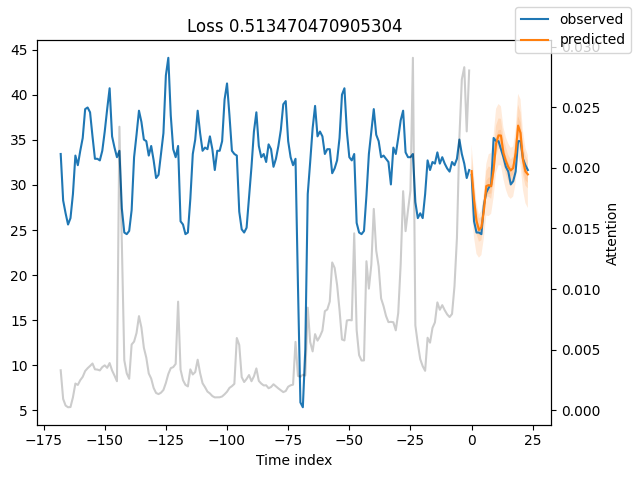

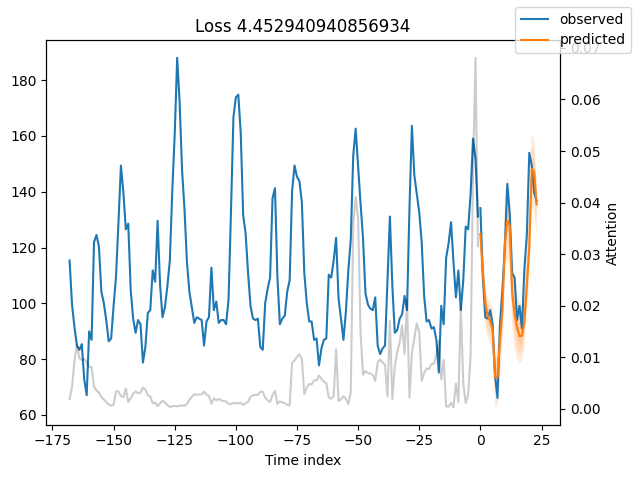

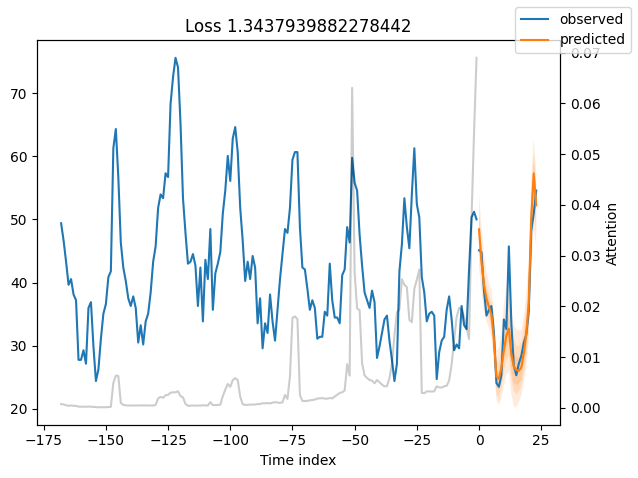

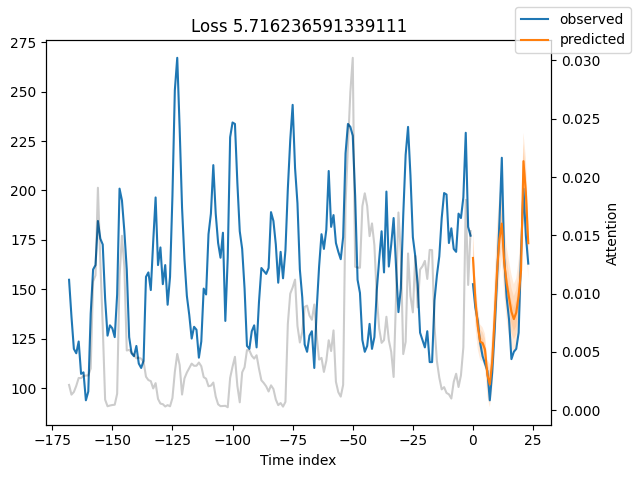

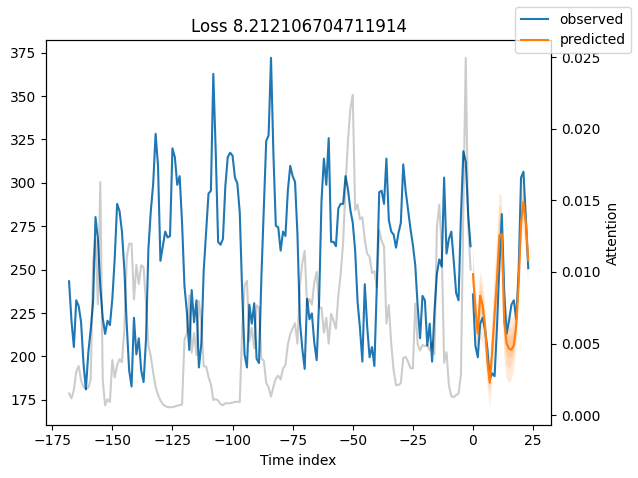

In [18]:
for idx in range(5):  # plot all 5 consumers
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True)

In [27]:
raw_predictions, x = best_tft.predict(test_dataloader, mode="raw", return_x=True)
print(raw_predictions._fields)
# ('prediction', 
# 'encoder_attention', 
# 'decoder_attention', 
# 'static_variables', 
# 'encoder_variables', 
# 'decoder_variables', 
# 'decoder_lengths', 
# 'encoder_lengths')

print('\n')
print(raw_predictions['prediction'].shape)

/Users/i0495036/Documents/sandbox/ml_investing_wne/.venv/lib/python3.9/site-packages/pytorch_forecasting/models/base_model.py:92: UserWarning: Not all dimensions are equal for tensors shapes. Example tensor torch.Size([640, 24, 4, 168]). Returning list instead of torch.Tensor.
  warnings.warn(


('prediction', 'encoder_attention', 'decoder_attention', 'static_variables', 'encoder_variables', 'decoder_variables', 'decoder_lengths', 'encoder_lengths')


torch.Size([13920, 24, 7])


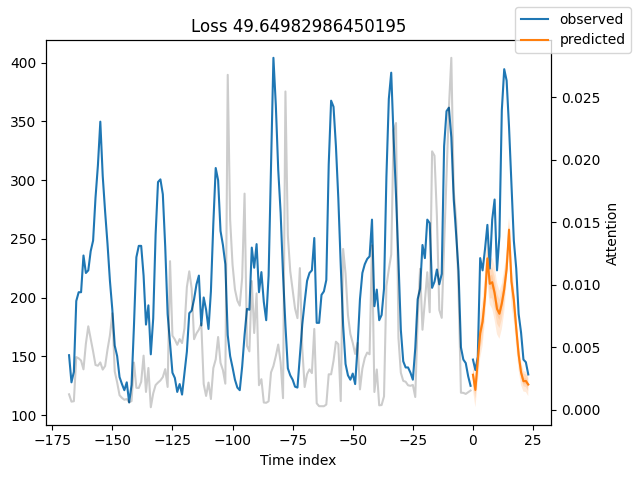

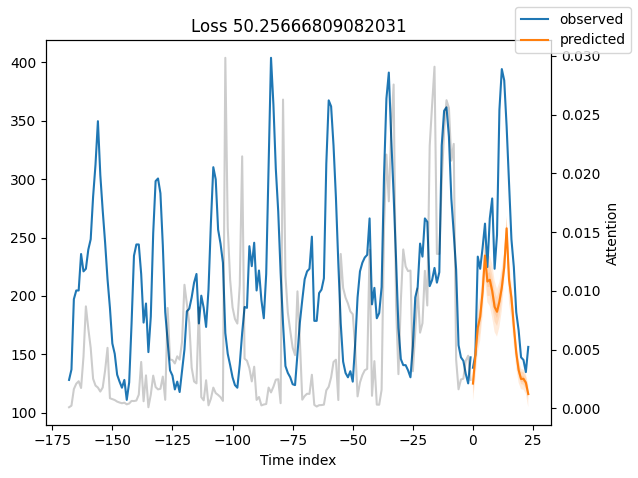

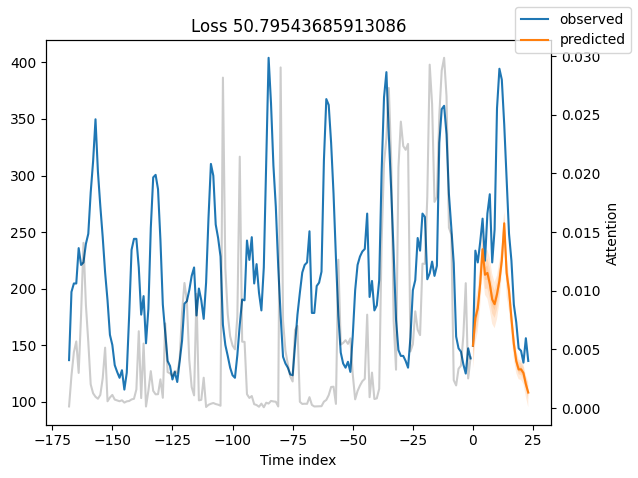

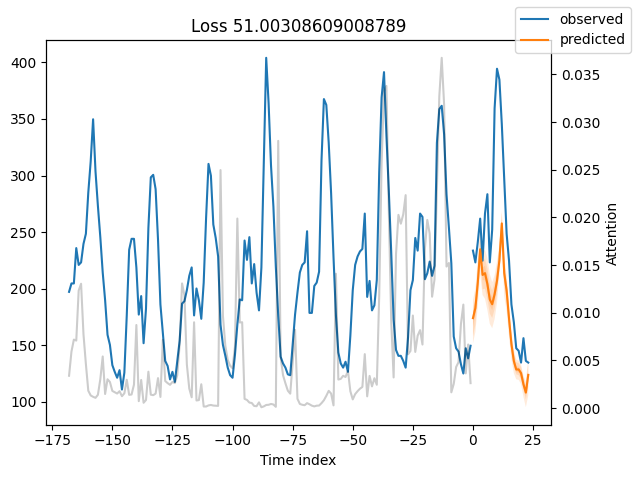

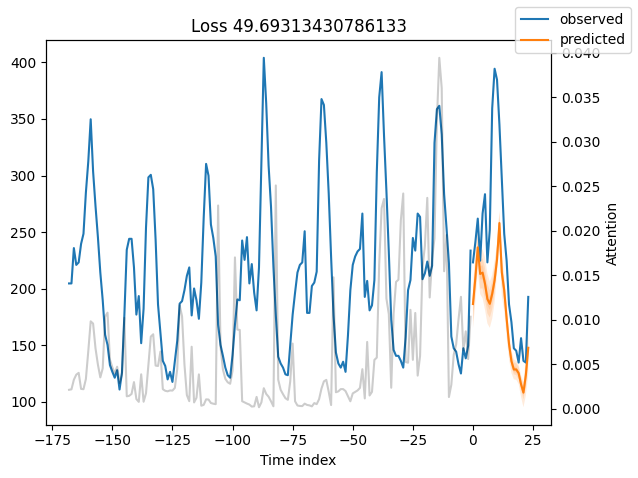

In [31]:
for idx in range(10005, 10010):  # plot all 5 consumers
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True)